# Chapter 04 패션 아이템을 구분하는 DNN

## 4.1 Fashion MNIST 데이터셋 알아보기

In [29]:
from torchvision import datasets, transforms, utils
from torch.utils import data

In [30]:
import matplotlib.pyplot as plt
import numpy as np

이미지를 텐서로 바꿔주는 코드

In [31]:
transform = transforms.Compose([
    transforms.ToTensor()
])

토치비전 Transforms에서 자주 쓰이는 기능
* ToTensor : 이미지를 파이토치 텐서로 변환
* Resize : 이미지 크기 조정
* Normalize : 주어진 평균과 표준편차를 이용하여 정규화
* RandomHorizontalFlip : 무작위로 이미지의 오른쪽과 왼쪽을 뒤집는 기능
* RandomCrop : 이미지를 무작위로 자르는 기능

FashionMNIST 데이터셋 가져오기

In [32]:
trainset = datasets.FashionMNIST(
    root        = './.data/',
    train       = True,
    download    = True,
    transform   = transform
)
testset = datasets.FashionMNIST(
    root        = './.data/',
    train       = False,
    download    = True,
    transform   = transform
)

torchvision.datasets로 생성된 객체는 파이토치 내부 클래스 'torch.utils.data.Dataset'을 상속함.<br/>
따라서 파이토치의 'DataLoader', 즉 데이터셋을 로딩하는 클래스에 넣어 바로 사용 가능.<br/>
'DataLoader'는 데이터셋을 비치 단위로 쪼개고 학습 시 반복문 안에서 데이터를 공급하주는 클래스

데이터로더의 매개변수에 앞서 불러온 데이터셋을 넣어주고 배치 크기를 지정

In [33]:
batch_size = 16

train_loader = data.DataLoader(
    dataset    = trainset,
    batch_size  = batch_size
)
test_loader = data.DataLoader(
    dataset    = testset,
    batch_size  = batch_size
)

보통 for문안에 넣어서 사용하면 되지만, 배치 1개만 뽑아 데이터가 어떻게 생겼는지 체크

In [34]:
dataiter        = iter(train_loader)  # iter 함수에 넣어 반복문 안에서 이용할 수 있도록 만듬
images, labels  = next(dataiter)

In [35]:
# iter 써보기
a = iter([1,2,3])
next(a)
next(a)
next(a)
# next(a) # 다음이 없으면 오류

3

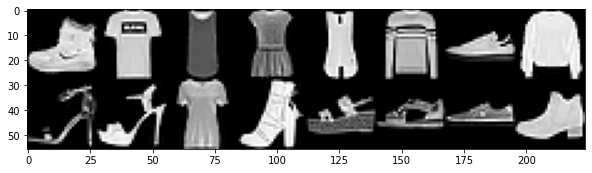

In [36]:
img   = utils.make_grid(images, padding=0) # make_grid는 여러 이미지를 모아 하나의 이미지로
npimg = img.numpy() # 텐서를 plt와 호환되는 넘파이 배열로 변경
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1,2,0))) # plt가 인식하는 차원의 순서가 다르므로 첫번째 차원을 맨 뒤로 보냄.
plt.show()

In [37]:
print(labels)

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9])


해석에 용이하게 레이블의 딕셔너리 만들기

In [38]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [39]:
for label in labels:
    index = label.item()  # tensor형태라 items로 바꿔줘야됨
    print(CLASSES[index])

Ankle boot
T-shirt/top
T-shirt/top
Dress
T-shirt/top
Pullover
Sneaker
Pullover
Sandal
Sandal
T-shirt/top
Ankle boot
Sandal
Sandal
Sneaker
Ankle boot


개별 이미지 꺼내 보기

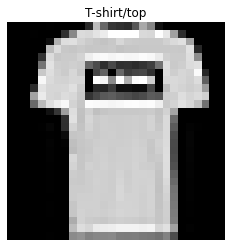

In [40]:
idx = 1
item_img = images[idx]
item_nimg = item_img.squeeze().numpy()
plt.title(CLASSES[labels[idx].item()])
plt.imshow(item_nimg, cmap='gray')
plt.axis('off')
plt.show()

전체코드 맛보기

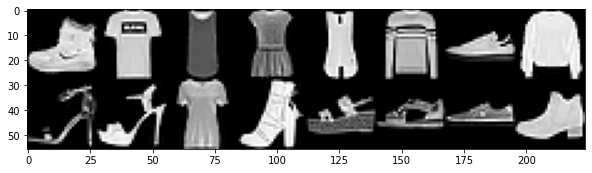

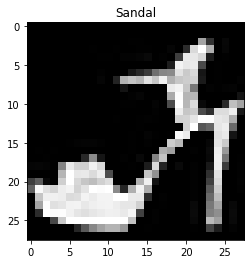

In [41]:
from torchvision import datasets, transforms, utils
from torch.utils import data

import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
        transforms.ToTensor()
])

trainset = datasets.FashionMNIST(
    root        = './.data/',
    train       = True,
    download    = True,
    transform   = transform
)
testset = datasets.FashionMNIST(
    root        = './.data/',
    train       = False,
    download    = True,
    transform   = transform
)

batch_size = 16
train_loader = data.DataLoader(
    dataset       = trainset,
    batch_size    = batch_size
)
test_loader = data.DataLoader(
    dataset       = testset,
    batch_size    = batch_size
)

dataiter       = iter(train_loader)
images, labels = next(dataiter)

img     = utils.make_grid(images, padding=0)
npimg   = img.numpy()
plt.figure(figsize=(10,7))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

idx = 9
item_img = images[idx]
item_npimg = item_img.squeeze().numpy()
plt.title(CLASSES[labels[idx].item()])
plt.imshow(item_npimg, cmap='gray')
plt.show()

## 4.2 인공 신경망으로 패션 아이템 분류하기

### 4.2.1 환경 설정하기

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets

In [43]:
# CUDA 지원 여부 확인
# GPU 사용
torch.cuda.is_available()

True

In [44]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

배치 사이즈 설정
* 배치 크기와 모델 가중치 2의 거듭제곱으로 표현 많이함
* cpu와 gpu의 메모리 크기가 2의 배수이기 때문에 효율 좋음

In [45]:
EPOCHS = 30
BATCH_SIZE = 64

### 4.2.3 이미지 분류를 위한 인공 신경망 구현
* 3층 인공 신경망 구현

In [46]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    # 가중치가 없는 연산은 F에 있는 함수를 직접 사용하기도함
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

모델 선언과 동시에 to() 함수로 연산을 어디에서 수행할지 정할 수 있음

In [47]:
# 모델 선언
model = Net().to(DEVICE)

In [48]:
# SGD 활용
# 모델 내부정보를 넘겨주는 model.parameters() 함수와 학습률 전달
optimizer = optim.SGD(model.parameters(), lr=0.01)

* 학습에 들어가는 모든 연산은 train() 함수 안에서 해결
* 모델에 입력할 data 모양은 [64, 1, 28, 28]
* 모델의 가중치를 GPU로 보냈으면 학습 데이터도 같은 장치로 보내야 연산 가능

In [49]:
# 학습할 모델, 데이터 공급, 옵티마이저 전달
def train(model, train_loader, optimizer):
    # 학습 모드로 변경
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        # 학습 데이터를 DEVICE의 메모리로 보냄
        data, target = data.to(DEVICE), target.to(DEVICE)
        # 가중치를 보관할 필요가 없어 F의 cross_entropy 함수 직접 사용
        optimizer.zero_grad() # 새로 계산
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()  # 기울기 계산
        optimizer.step() # 가중치 수정

## 4.3 성능 측정하기
* 학습셋은 가중치 조절, 검증셋은 배치 크기와 모델 설계같은 하이퍼 파라미터 조절, 테스트셋은 성능 보고

In [55]:
# 이폭이 끝날 때마다 테스트셋으로 모델의 성능 측정
def evaluate(model, test_loader):
    # 평가 모드
    model.eval()
    test_loss = 0
    correct = 0

    # 평가중에는 기울기 계산이 필요없으므로 다음과 같이 설정
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 모든 오차 더하기
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 큰 값을 가진 클래스가 모델의 예측
            # 예측과 정답을 비교하여 일치할 경우 correct에 1을 더함.
            pred = output.max(1, keepdim=True)[1]  # 가장큰 값과 그 인덱스 반환
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [56]:
# 학습
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)

    print(f"[{epoch}] Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")

[1] Test Loss: 0.3307, Accuracy: 88.11%
[2] Test Loss: 0.3312, Accuracy: 88.24%
[3] Test Loss: 0.3309, Accuracy: 88.23%
[4] Test Loss: 0.3307, Accuracy: 88.35%
[5] Test Loss: 0.3320, Accuracy: 88.39%
[6] Test Loss: 0.3318, Accuracy: 88.42%
[7] Test Loss: 0.3331, Accuracy: 88.50%
[8] Test Loss: 0.3351, Accuracy: 88.43%
[9] Test Loss: 0.3363, Accuracy: 88.60%
[10] Test Loss: 0.3371, Accuracy: 88.54%
[11] Test Loss: 0.3393, Accuracy: 88.68%
[12] Test Loss: 0.3408, Accuracy: 88.69%
[13] Test Loss: 0.3416, Accuracy: 88.64%
[14] Test Loss: 0.3425, Accuracy: 88.67%
[15] Test Loss: 0.3453, Accuracy: 88.65%
[16] Test Loss: 0.3455, Accuracy: 88.80%
[17] Test Loss: 0.3468, Accuracy: 88.70%
[18] Test Loss: 0.3492, Accuracy: 88.74%
[19] Test Loss: 0.3521, Accuracy: 88.74%
[20] Test Loss: 0.3574, Accuracy: 88.66%
[21] Test Loss: 0.3561, Accuracy: 88.82%
[22] Test Loss: 0.3624, Accuracy: 88.62%
[23] Test Loss: 0.3654, Accuracy: 88.53%
[24] Test Loss: 0.3689, Accuracy: 88.66%
[25] Test Loss: 0.3701, A

16번째 에폭에서 이미 정확도 최고치나옴

## 4.4 과적합과 드롭아웃

### 4.4.1 데이터 늘리기

In [62]:
# 데이터로더에 토치비전 데이터셋을 직접 넣어 간결하게 만든 코드
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./.data/',
                          train=True,
                          download=True,
                          transform=transforms.Compose([
                          transforms.RandomHorizontalFlip(),
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                          ])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./.data/',
                          train=False,
                          download=True,
                          transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                          ])),
    batch_size=BATCH_SIZE, shuffle=True)

이미지 뒤집은 후 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


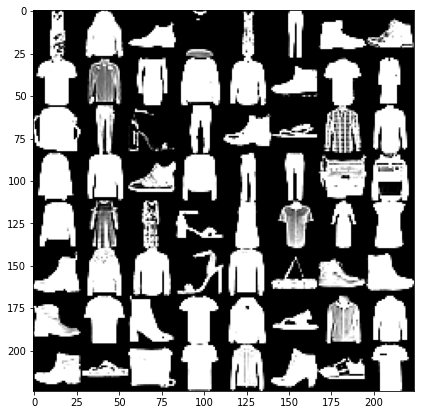

In [65]:
train_iter = iter(train_loader)
images, labels = next(train_iter)

img = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(10,7))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

사진 일부가 뒤집힌게 확인됨

### 4.4.2 드롭아웃

In [67]:
# 드롭아웃 구현
class Net(nn.Module):
    def __init__(self, dropout_p=0.2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

        # 드롭아웃 확률
        self.dropout_p = dropout_p

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(fc1(x))
        # 드롭아웃 추가
        x = F.dropout(x, training=self.training,
                      p=self.dropout_p)
        x = F.relu(self.fc2(x))
        # 드롭아웃 추가
        x = F.dropout(x, training=self.training,
                      p=self.dropout_p)
        x = self.fc3(x)
        return x

In [69]:
# 모델을 인스턴스화할 때 드롭아웃 확률을 추가
model = Net(dropout_p=0.2).to(DEVICE)

데이터셋에 노이즈를 추가하거나 모델에 드롭아웃을 적용하면 최고 성능에
도달하는 데 까지 걸리는 시간은 길어짐.<br/>
따라서 이폭을 늘려줄 필요가 있음.

### 전체 코드로 연습

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

EPOCHS = 50
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./.data/',
                          train=True,
                          download=True,
                          transform=transforms.Compose([
                          transforms.RandomHorizontalFlip(),
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                          ])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./.data/',
                          train=False,
                          download=True,
                          transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                          ])),
    batch_size=BATCH_SIZE, shuffle=True)

class Net(nn.Module):
    def __init__(self, dropout_p=0.2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout_p = dropout_p

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))

        # 드롭아웃 추가
        x = F.dropout(x, training=self.training,
                      p=self.dropout_p)
        x = F.relu(self.fc2(x))

        # 드롭아웃 추가
        x = F.dropout(x, training=self.training,
                      p=self.dropout_p)
        x = self.fc3(x)
        return x

In [79]:
model = Net(dropout_p=0.2).to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01)

def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 맞힌 개수 계산
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)

    print(f"[{epoch}] Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")

[1] Test Loss: 0.6465, Accuracy: 77.28%
[2] Test Loss: 0.5356, Accuracy: 80.63%
[3] Test Loss: 0.4868, Accuracy: 82.29%
[4] Test Loss: 0.4625, Accuracy: 83.34%
[5] Test Loss: 0.4435, Accuracy: 83.75%
[6] Test Loss: 0.4344, Accuracy: 84.04%
[7] Test Loss: 0.4267, Accuracy: 84.13%
[8] Test Loss: 0.4029, Accuracy: 85.44%
[9] Test Loss: 0.3965, Accuracy: 85.57%
[10] Test Loss: 0.3892, Accuracy: 85.93%
[11] Test Loss: 0.3820, Accuracy: 86.04%
[12] Test Loss: 0.3880, Accuracy: 85.75%
[13] Test Loss: 0.3711, Accuracy: 86.74%
[14] Test Loss: 0.3649, Accuracy: 86.82%
[15] Test Loss: 0.3662, Accuracy: 86.73%
[16] Test Loss: 0.3636, Accuracy: 86.78%
[17] Test Loss: 0.3560, Accuracy: 87.16%
[18] Test Loss: 0.3561, Accuracy: 86.90%
[19] Test Loss: 0.3480, Accuracy: 87.21%
[20] Test Loss: 0.3587, Accuracy: 87.07%
[21] Test Loss: 0.3449, Accuracy: 87.47%
[22] Test Loss: 0.3478, Accuracy: 87.49%
[23] Test Loss: 0.3442, Accuracy: 87.33%
[24] Test Loss: 0.3384, Accuracy: 87.77%
[25] Test Loss: 0.3364, A

데이터를 늘리고 드롭아웃을 적용하니 성능이 상당히 좋아짐을 볼 수 있음.